In [1]:
# Check if running in Google Colab
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

    # Define the base path for your data directory for Colab
    basePath = '/content/drive/MyDrive'

else:
    # Running locally or in a different environment
    basePath = '..'

In [2]:
import pandas as pd
import numpy as np

In [3]:
tavg_change = pd.read_csv(f"{basePath}/data/processed/tavg_change.csv")
df_grouped = pd.read_csv(f"{basePath}/data/processed/grouped_data2.csv")

In [ ]:
top_tavg_increase_countries = tavg_change[tavg_change['TAVG_Change_Percent'] > 0].sort_values(by='TAVG_Change_Percent', ascending=False).head(5) # Let's take top 5 for prediction

top_tavg_increase_country_names = top_tavg_increase_countries['COUNTRY'].tolist()

print("Top countries with the largest percentage increase in Average Temperature (TAVG):")
print(top_tavg_increase_country_names)

Top countries with the largest percentage increase in Average Temperature (TAVG):
['Antarctica', 'Jan Mayen [Norway]', 'Greenland [Denmark]', 'Finland', 'Austria']


In [ ]:
# Define the historical period for forecasting
start_year_historical = 2000
end_year_historical = 2025

df_tavg_historical = df_grouped[
    (df_grouped['COUNTRY'].isin(top_tavg_increase_country_names)) &
    (df_grouped['DATE'] >= start_year_historical) &
    (df_grouped['DATE'] <= end_year_historical)
].copy()

df_tavg_historical.sort_values(by=['COUNTRY', 'DATE'], inplace=True)

print("Historical TAVG data for top countries (2000-2025):")
display(df_tavg_historical.head())

print(f"\nNumber of data points for forecasting: {len(df_tavg_historical)}")

Historical TAVG data for top countries (2000-2025):


,COUNTRY,DATE,LATITUDE,LONGITUDE,ELEVATION,CDSD,CLDD,DP01,DP10,DT00,...,FZF0,FZF5,FZF6,HDSD,HDSD_ATTRIBUTES,HTDD,PRCP,TAVG,TMAX,TMIN
191,Antarctica,2000,-64.646400,6.0068,56.800000,0.0,0.0,NaN,NaN,67.400000,...,-3.500000,-2.500000,-3.760000,7881.233333,2.333333,7881.233333,NaN,-6.240000,-3.020000,-9.520000
192,Antarctica,2001,-62.788667,-52.8110,76.666667,0.0,0.0,NaN,NaN,52.333333,...,-4.566667,-1.000000,-2.766667,8217.200000,2.000000,8217.200000,NaN,-5.150000,-2.000000,-7.866667
193,Antarctica,2002,-62.788667,-52.8110,76.666667,0.0,0.0,NaN,NaN,62.666667,...,-0.766667,-1.100000,-3.300000,8534.033333,0.333333,8534.033333,NaN,-5.566667,-2.333333,-8.800000
194,Antarctica,2003,-62.788667,-52.8110,76.666667,0.0,0.0,NaN,NaN,61.000000,...,-1.666667,-2.933333,-3.533333,8404.266667,2.666667,8404.266667,NaN,-5.133333,-1.766667,-8.533333
195,Antarctica,2010,-69.183500,68.6085,430.000000,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.400000,NaN



Number of data points for forecasting: 115


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import warnings

arima_order = (5, 1, 0) 

trained_arima_models = {}

training_errors = {}

warnings.filterwarnings("ignore")

print("Training ARIMA models for each top country:")

for country in top_tavg_increase_country_names:
    print(f"Training model for {country}...")
    # Filter data for the current country
    country_data = df_tavg_historical[df_tavg_historical['COUNTRY'] == country].copy()

    # Set the DATE as the index for time series analysis
    country_data.set_index('DATE', inplace=True)

    # Ensure the data is sorted by date
    country_data.sort_index(inplace=True)

    ts_data = country_data['TAVG']


    ts_data = ts_data.interpolate(method='linear')
    ts_data.dropna(inplace=True) 
    if ts_data.empty:
        print(f"  Skipping {country}: Insufficient data after handling missing values.")
        training_errors[country] = "Insufficient data"
        continue

    try:
        # Train the ARIMA model
        model = ARIMA(ts_data, order=arima_order)
        model_fit = model.fit()
        trained_arima_models[country] = model_fit
        print(f"  Model trained successfully for {country}.")
        import os
        import pickle

        models_dir = f"{basePath}/models"
        os.makedirs(models_dir, exist_ok=True)

        model_path = os.path.join(models_dir, f"{country.replace(' ', '_')}_arima.pkl")
        with open(model_path, "wb") as f:
            pickle.dump(model_fit, f)
        print(f"  Model saved to {model_path}")
    except Exception as e:
        print(f"  Error training model for {country}: {e}")
        training_errors[country] = str(e)

# Re-enable warnings
warnings.filterwarnings("default")

if training_errors:
    print("\nErrors encountered during training:")
    for country, error in training_errors.items():
        print(f"- {country}: {error}")

Training ARIMA models for each top country:
Training model for Antarctica...
  Model trained successfully for Antarctica.
  Model saved to ../models/Antarctica_arima.pkl
Training model for Jan Mayen [Norway]...
  Model trained successfully for Jan Mayen [Norway].
  Model saved to ../models/Jan_Mayen_[Norway]_arima.pkl
Training model for Greenland [Denmark]...
  Model trained successfully for Greenland [Denmark].
  Model saved to ../models/Greenland_[Denmark]_arima.pkl
Training model for Finland...
  Model trained successfully for Finland.
  Model saved to ../models/Finland_arima.pkl
Training model for Austria...
  Model trained successfully for Austria.
  Model saved to ../models/Austria_arima.pkl

Finished training models.


In [ ]:
# Define the number of years to forecast
n_forecast_years = 5

forecasts = {}

print("Generating forecasts for the next 5 years:")

for country, model_fit in trained_arima_models.items():
    print(f"Forecasting for {country}...")
    try:

        forecast_result = model_fit.forecast(steps=n_forecast_years)

        forecasts[country] = forecast_result
        print(f"  Forecast generated successfully for {country}.")
    except Exception as e:
        print(f"  Error generating forecast for {country}: {e}")
        forecasts[country] = f"Error: {e}"


# Display the forecasts
print("\nForecasted TAVG values (2026-2030):")
for country, forecast_data in forecasts.items():
    print(f"\n{country}:")
    display(forecast_data)

Generating forecasts for the next 5 years:
Forecasting for Antarctica...
  Forecast generated successfully for Antarctica.
Forecasting for Jan Mayen [Norway]...
  Forecast generated successfully for Jan Mayen [Norway].
Forecasting for Greenland [Denmark]...
  Forecast generated successfully for Greenland [Denmark].
Forecasting for Finland...
  Forecast generated successfully for Finland.
Forecasting for Austria...
  Forecast generated successfully for Austria.

Finished generating forecasts.

Forecasted TAVG values (2026-2030):

Antarctica:


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


16   -11.004951
17   -11.941241
18   -13.130781
19   -13.942149
20   -14.496478
Name: predicted_mean, dtype: float64


Jan Mayen [Norway]:


26    0.608578
27    0.679347
28    0.671338
29    0.650327
30    0.665332
Name: predicted_mean, dtype: float64


Greenland [Denmark]:


24    -9.648737
25    -9.278593
26    -9.657272
27   -10.168418
28    -9.933631
Name: predicted_mean, dtype: float64


Finland:


25    3.692338
26    4.117616
27    3.579729
28    3.818419
29    3.609971
Name: predicted_mean, dtype: float64


Austria:


24    6.657512
25    6.244988
26    6.370366
27    6.728034
28    6.684708
Name: predicted_mean, dtype: float64

Generating line charts with historical data and forecasts and saving to ../reports/figures/future_trends:
Figure saved to ../reports/figures/future_trends/Antarctica_tavg_forecast.png


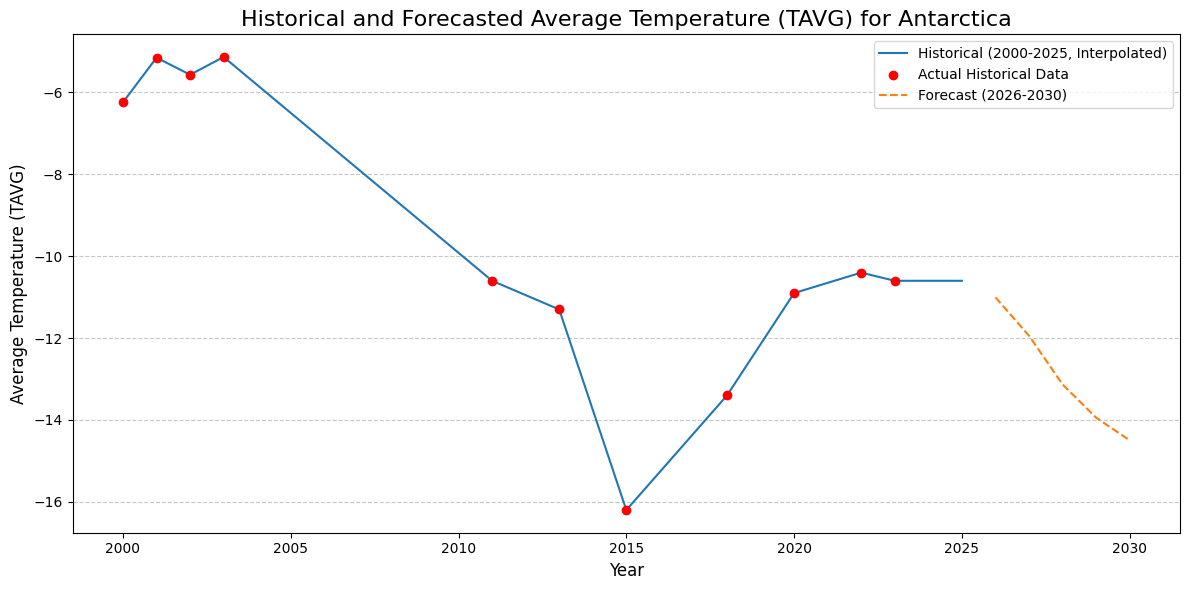

--------------------------------------------------
Figure saved to ../reports/figures/future_trends/Jan_Mayen_Norway_tavg_forecast.png


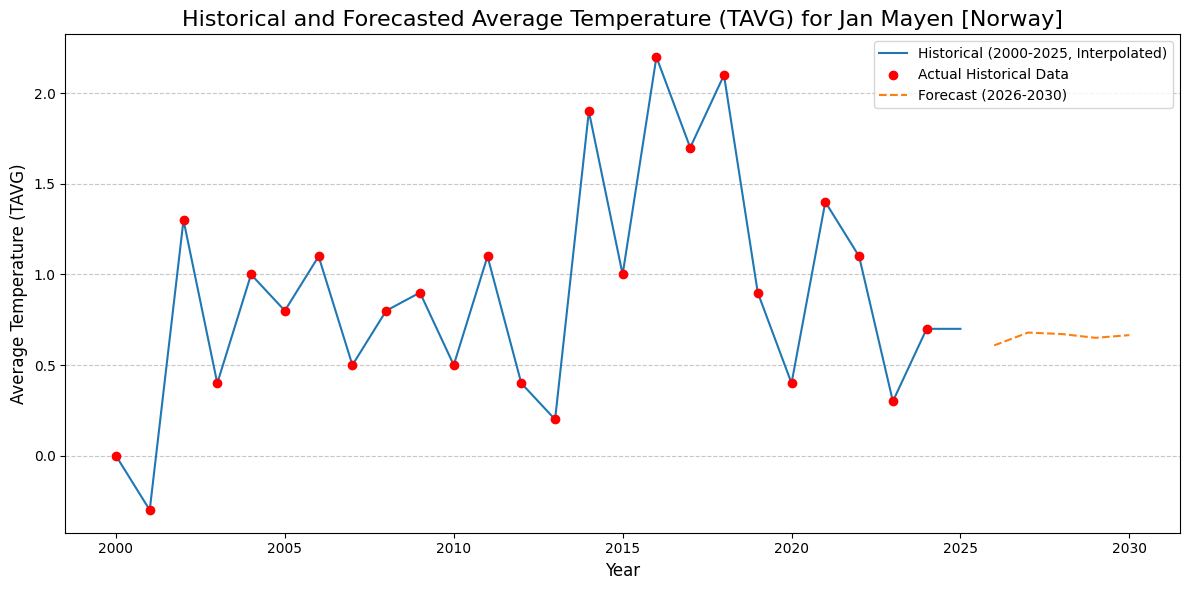

--------------------------------------------------
Figure saved to ../reports/figures/future_trends/Greenland_Denmark_tavg_forecast.png


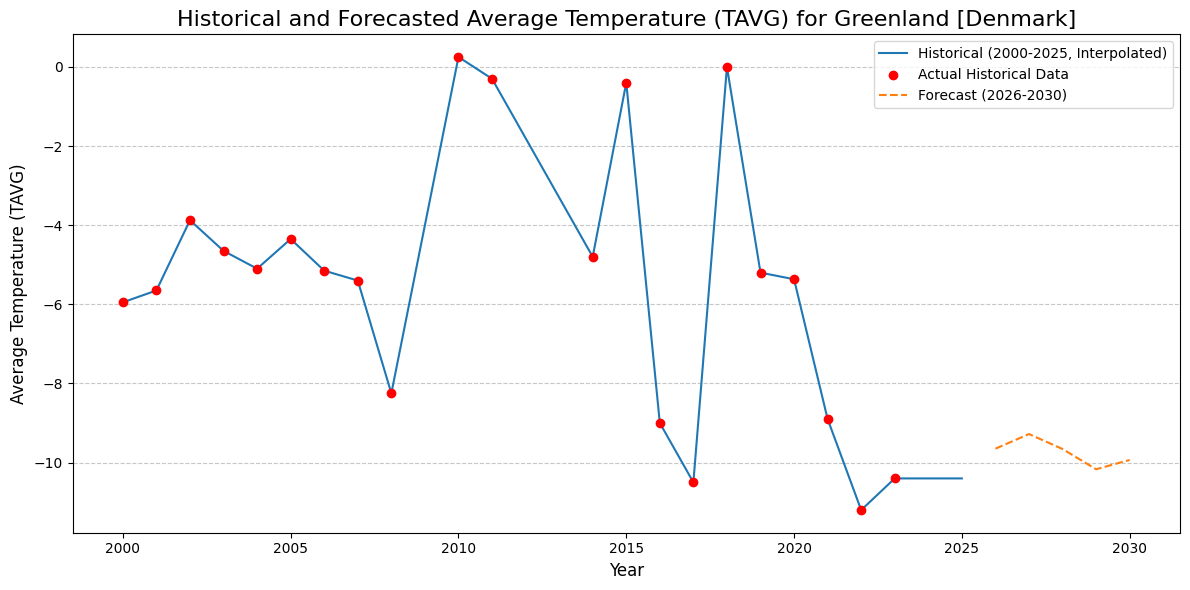

--------------------------------------------------
Figure saved to ../reports/figures/future_trends/Finland_tavg_forecast.png


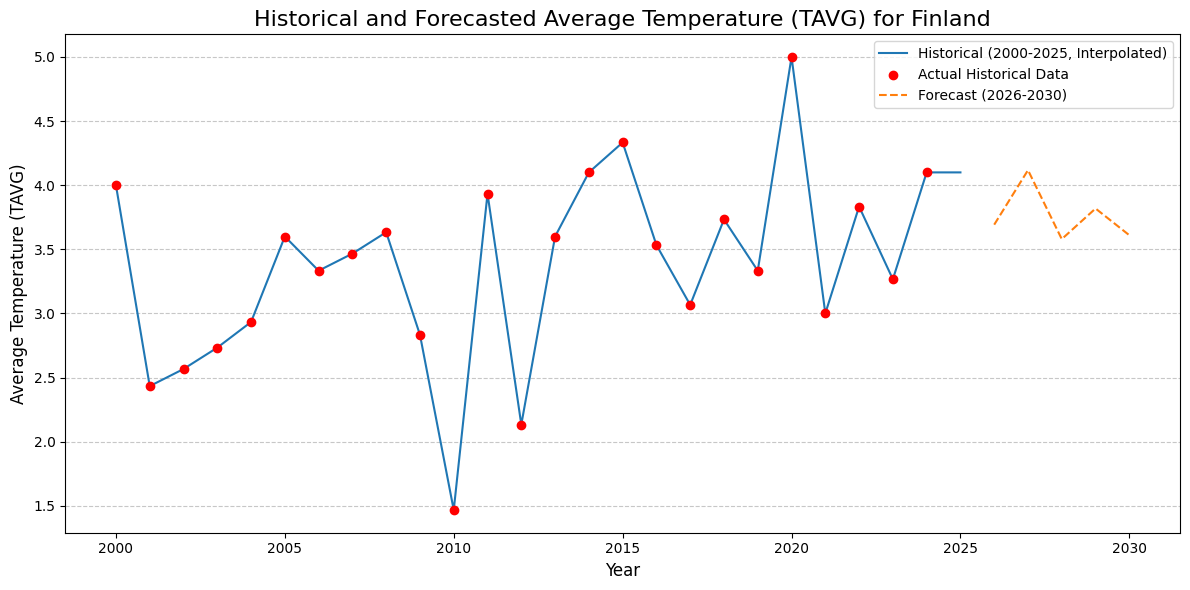

--------------------------------------------------
Figure saved to ../reports/figures/future_trends/Austria_tavg_forecast.png


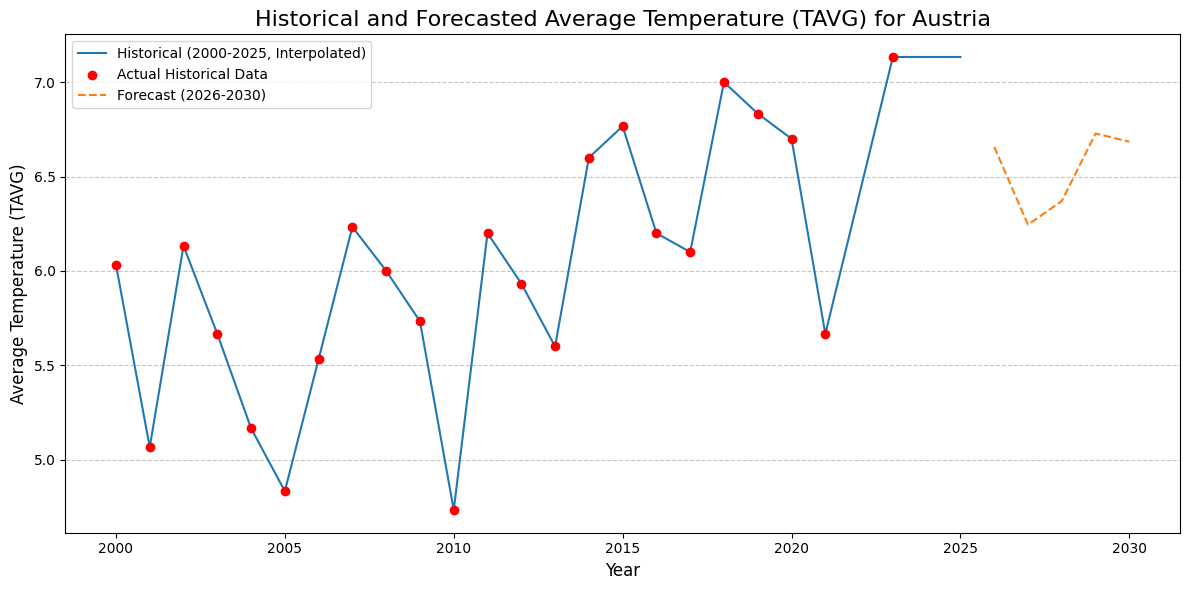

--------------------------------------------------

Finished generating historical and forecast line charts.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Define the historical and forecast periods
start_year_historical = 2000
end_year_historical = 2025
start_year_forecast = end_year_historical + 1
end_year_forecast = end_year_historical + n_forecast_years

# Define the directory to save the figures
figures_dir = f"{basePath}/reports/figures/future_trends"

# Create the directory if it doesn't exist
os.makedirs(figures_dir, exist_ok=True)

print(f"Generating line charts with historical data and forecasts and saving to {figures_dir}:")

# Iterate through each top country and its forecast
for country, forecast_data in forecasts.items():
    # Ensure the forecast data is a pandas Series for plotting
    if not isinstance(forecast_data, pd.Series):
        print(f"Skipping visualization for {country}: Forecast data is not a pandas Series.")
        continue

    plt.figure(figsize=(12, 6))

    historical_data = df_tavg_historical[df_tavg_historical['COUNTRY'] == country].copy()
    historical_data.set_index('DATE', inplace=True)
    historical_data.sort_index(inplace=True)

    complete_historical_index = pd.RangeIndex(start=start_year_historical, stop=end_year_historical + 1, step=1)
    historical_data = historical_data.reindex(complete_historical_index)

    historical_data['TAVG_interpolated'] = historical_data['TAVG'].interpolate(method='linear')

    plt.plot(historical_data.index, historical_data['TAVG_interpolated'], label='Historical (2000-2025, Interpolated)', linestyle='-')

    original_historical_points = df_tavg_historical[df_tavg_historical['COUNTRY'] == country].copy()
    plt.scatter(original_historical_points['DATE'], original_historical_points['TAVG'], color='red', zorder=5, label='Actual Historical Data') # Plot original points as dots

    forecast_years_index = pd.RangeIndex(start=start_year_forecast, stop=end_year_forecast + 1, step=1)
    forecast_series_with_years = pd.Series(forecast_data.values, index=forecast_years_index)

    forecast_series_with_years.index = pd.to_numeric(forecast_series_with_years.index)

    plt.plot(forecast_series_with_years.index, forecast_series_with_years.values, label='Forecast (2026-2030)', linestyle='--')

    plt.title(f'Historical and Forecasted Average Temperature (TAVG) for {country}', fontsize=16)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Average Temperature (TAVG)', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    # Adjust legend to avoid overlap if needed, or rely on default placement with tight_layout
    plt.legend()
    plt.tight_layout()

    filename = f"{country.replace(' ', '_').replace('[', '').replace(']', '')}_tavg_forecast.png"
    filepath = os.path.join(figures_dir, filename)
    plt.savefig(filepath)
    print(f"Figure saved to {filepath}")

    plt.show()

    print("-" * 50) # Separator for clarity
